In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score


In [2]:
chunks = []
for chunk in pd.read_csv('Building_and_Safety_Inspections_20250505.csv', chunksize=100000):
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
display(df.head())

,ADDRESS,PERMIT,Permit Status,Inspection Date,Inspection Type,Inspection Result,Latitude/Longitude
0,10000 W SANTA MONICA BLVD,14044 10000 02293,Issued,07/20/2016,Rough-Ventilation,Partial Approval,"(34.06364, -118.41437)"
1,1000 S SANTA FE AVE,15016 10000 18196,Permit Finaled,07/22/2016,Smoke Detectors,Insp Cancelled,"(34.03143, -118.22981)"
2,3680 N BUENA PARK DR,15014 10000 04931,Issued,07/18/2016,Insulation,Approved,"(34.13745, -118.38853)"
3,1001 N LINDENWOOD LANE,16042 90000 14712,Permit Finaled,07/20/2016,Final,Permit Finaled,"(34.07732, -118.48578)"
4,2836 S ANCHOR AVE,15016 20001 17211,CofO Issued,07/18/2016,Inspection,Permit Finaled,"(34.03878, -118.39963)"


In [3]:
def eda(df):
    print("\nShape:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nSummary Stats:\n", df.describe(include='all'))

eda(df)


Shape: (10396028, 7)

Data Types:
 ADDRESS               object
PERMIT                object
Permit Status         object
Inspection Date       object
Inspection Type       object
Inspection Result     object
Latitude/Longitude    object
dtype: object

Missing Values:
 ADDRESS                    1
PERMIT                     0
Permit Status         481120
Inspection Date       205257
Inspection Type       481137
Inspection Result     481421
Latitude/Longitude    481120
dtype: int64

Summary Stats:
               ADDRESS             PERMIT Permit Status Inspection Date   
count        10396027           10396028       9914908        10190771  \
unique         640010            1731527            46            4054   
top     300 WORLD WAY  16014 10001 02498        Issued      05/11/2023   
freq            14562              10150       7230192           16164   

       Inspection Type Inspection Result     Latitude/Longitude  
count          9914891           9914607                991

In [11]:
# Fix data types
pd.to_datetime(df['Inspection Date'], errors='coerce')
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'], errors='coerce')

cols_to_category = ['Permit Status', 'Inspection Type', 'Inspection Result']
df[cols_to_category] = df[cols_to_category].astype('category')

# Separate Latitude and Longitude
df[['Latitude', 'Longitude']] = df['Latitude/Longitude'].str.strip('()').str.split(',', expand=True)
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

display("\nData Types:\n", df.dtypes)

'\nData Types:\n'

ADDRESS                       object
PERMIT                        object
Permit Status               category
Inspection Date       datetime64[ns]
Inspection Type             category
Inspection Result           category
Latitude/Longitude            object
Latitude                     float64
Longitude                    float64
dtype: object

# Question 1
## Make a table and a visualization showing an interesting characteristic of the permit and inspection dataset.

The first thing that comes to mind is look at when and how often inspections are happening. I thought it was interesting to see the spikes in 2017 where there were drops in the numebr of inspections and the period in 2023 where there was a lot. Forest fires? COVID-19?

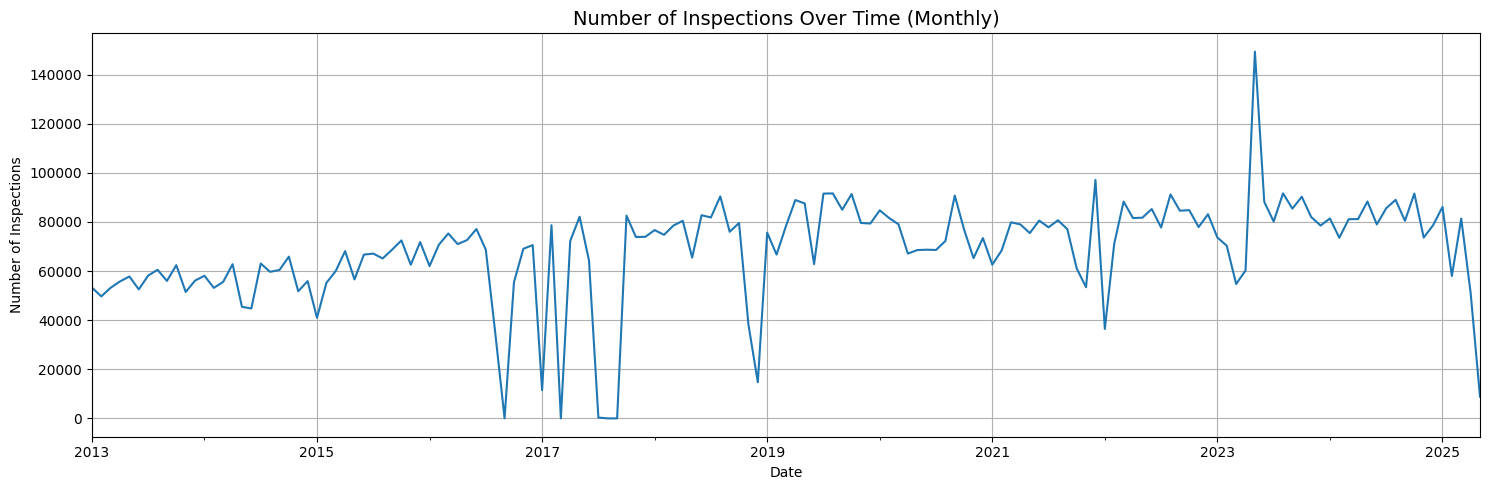

,Month,Inspection Count
0,2013-01,53281
1,2013-02,49682
2,2013-03,53193
3,2013-04,55791
4,2013-05,57788
...,...,...
144,2025-01,86099
145,2025-02,57996
146,2025-03,81389
147,2025-04,51151


In [7]:
monthly_counts = df.set_index('Inspection Date').resample('M').size()

plt.figure(figsize=(15, 5))
monthly_counts.plot()

# Plot
plt.title('Number of Inspections Over Time (Monthly)', fontsize=14)
plt.ylabel('Number of Inspections')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

# Table
monthly_table = monthly_counts.reset_index()
monthly_table.columns = ['Month', 'Inspection Count']
monthly_table['Month'] = monthly_table['Month'].dt.strftime('%Y-%m')

display(monthly_table)

# Question 2

### Make a table and a visualization showing the number of inspections by geography. In a sentence or two describe any patterns you observe.

There are three areas of LA that have a higher concentration of inspections around (34.05, -118.25), (34.05, -118.4) and (33.95, -118.95).

### Make a table and a visualization showing the results of inspections across geographies. In a sentence or two describe any patterns you observe.

There is a concentration of "Approved" inspections in the areas around (34.05, -118.4). 

### Were there any permits that did not get an inspection?

I have interpreted this question be records that have a permit but no inspection result which results in 481421 records returned

`count = df[df['Inspection Result'].isna() & df['PERMIT'].notna()].shape[0]
display(count) # shows 481421
`




In [61]:
address_counts = df['ADDRESS'].value_counts().reset_index()
address_counts.columns = ['ADDRESS', 'Inspection_Count']

print(address_counts)

                               ADDRESS  Inspection_Count
0                        300 WORLD WAY             14562
1           2025 S AVENUE OF THE STARS             11824
2                        380 WORLD WAY             11563
3                        400 WORLD WAY             10952
4                      100 S GRAND AVE             10612
...                                ...               ...
640005             13676 N GARRICK AVE                 1
640006          814 S WESTGATE AVE 101                 1
640007  13165 W FOOTHILL BLVD NO   108                 1
640008           16200 W MULHOLLAND DR                 1
640009     8701 S DELGANY AVE APT 0303                 1

[640010 rows x 2 columns]


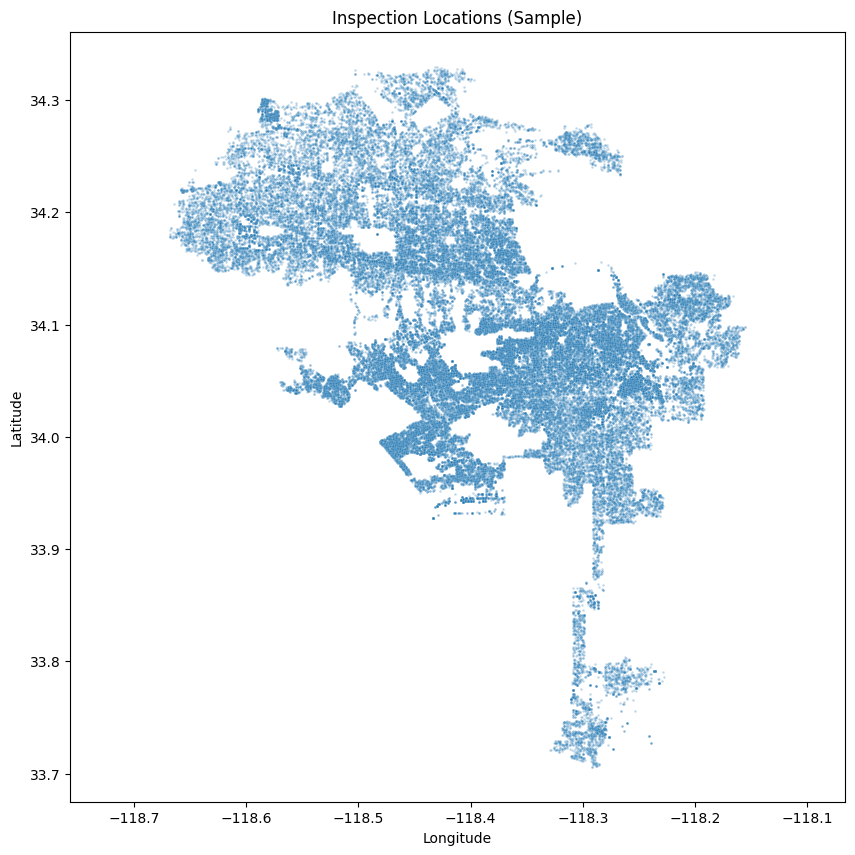

In [25]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=sample_df['Longitude'], y=sample_df['Latitude'], s=3, alpha=0.3) 

plt.title('Inspection Locations (Sample)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal') # Keep aspect ratio of map
plt.show()

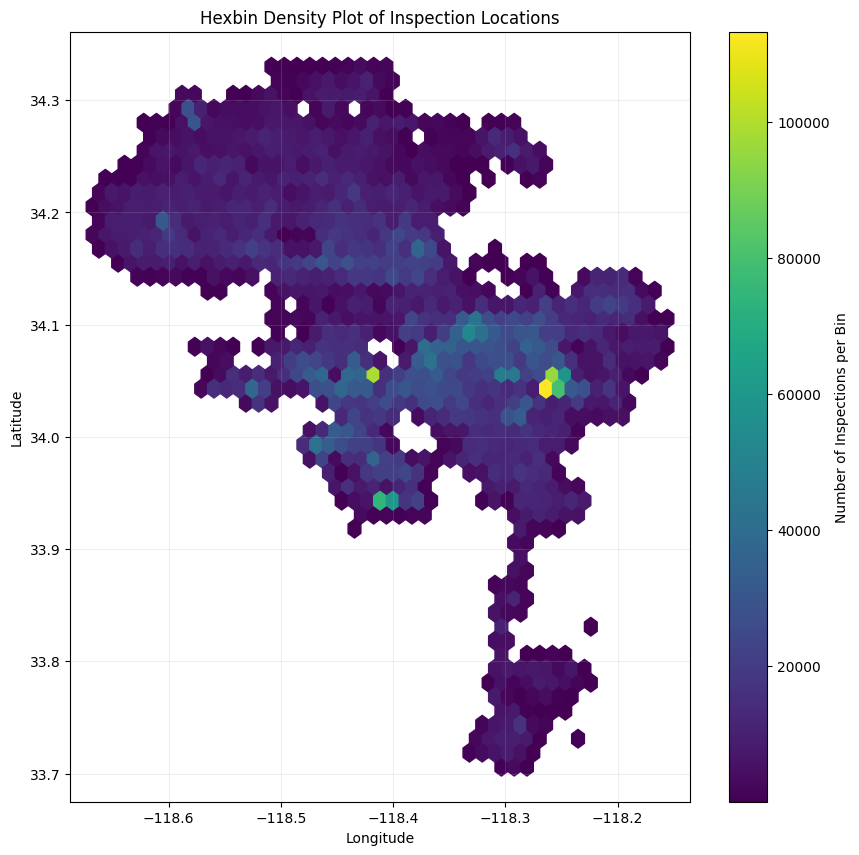

In [28]:
plot_df = df

plt.figure(figsize=(10, 10))

plt.hexbin(
    x=plot_df['Longitude'],
    y=plot_df['Latitude'],
    gridsize=45,
    cmap='viridis',
    mincnt=1
)

plt.colorbar(label='Number of Inspections per Bin')
plt.title('Hexbin Density Plot of Inspection Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal') 
plt.grid(True, alpha=0.2)
plt.show()

In [39]:
gridsize = 45
min_count_threshold = 1
display_bins = 25

table_df = df

# Create table
fig, ax = plt.subplots()

hb = ax.hexbin(
    table_df['Longitude'], table_df['Latitude'],
    gridsize=gridsize, mincnt=min_count_threshold
)

# Create DataFrame
hexbin_data_table = pd.DataFrame({
    'Center_Longitude': hb.get_offsets()[:, 0],
    'Center_Latitude': hb.get_offsets()[:, 1],
    'Inspection_Count': hb.get_array().astype(int)
}).sort_values('Inspection_Count', ascending=False)

plt.close(fig) 
display(hexbin_data_table.head(display_bins))

,Center_Longitude,Center_Latitude,Inspection_Count
864,-118.263733,34.042880,113335
212,-118.417396,34.055354,98944
419,-118.258042,34.055354,95552
877,-118.252351,34.042880,79731
673,-118.411705,33.943081,74183
689,-118.400323,33.943081,60244
430,-118.246660,34.055354,58688
769,-118.332028,34.092779,52641
352,-118.303572,34.055354,46845
370,-118.292189,34.055354,45337


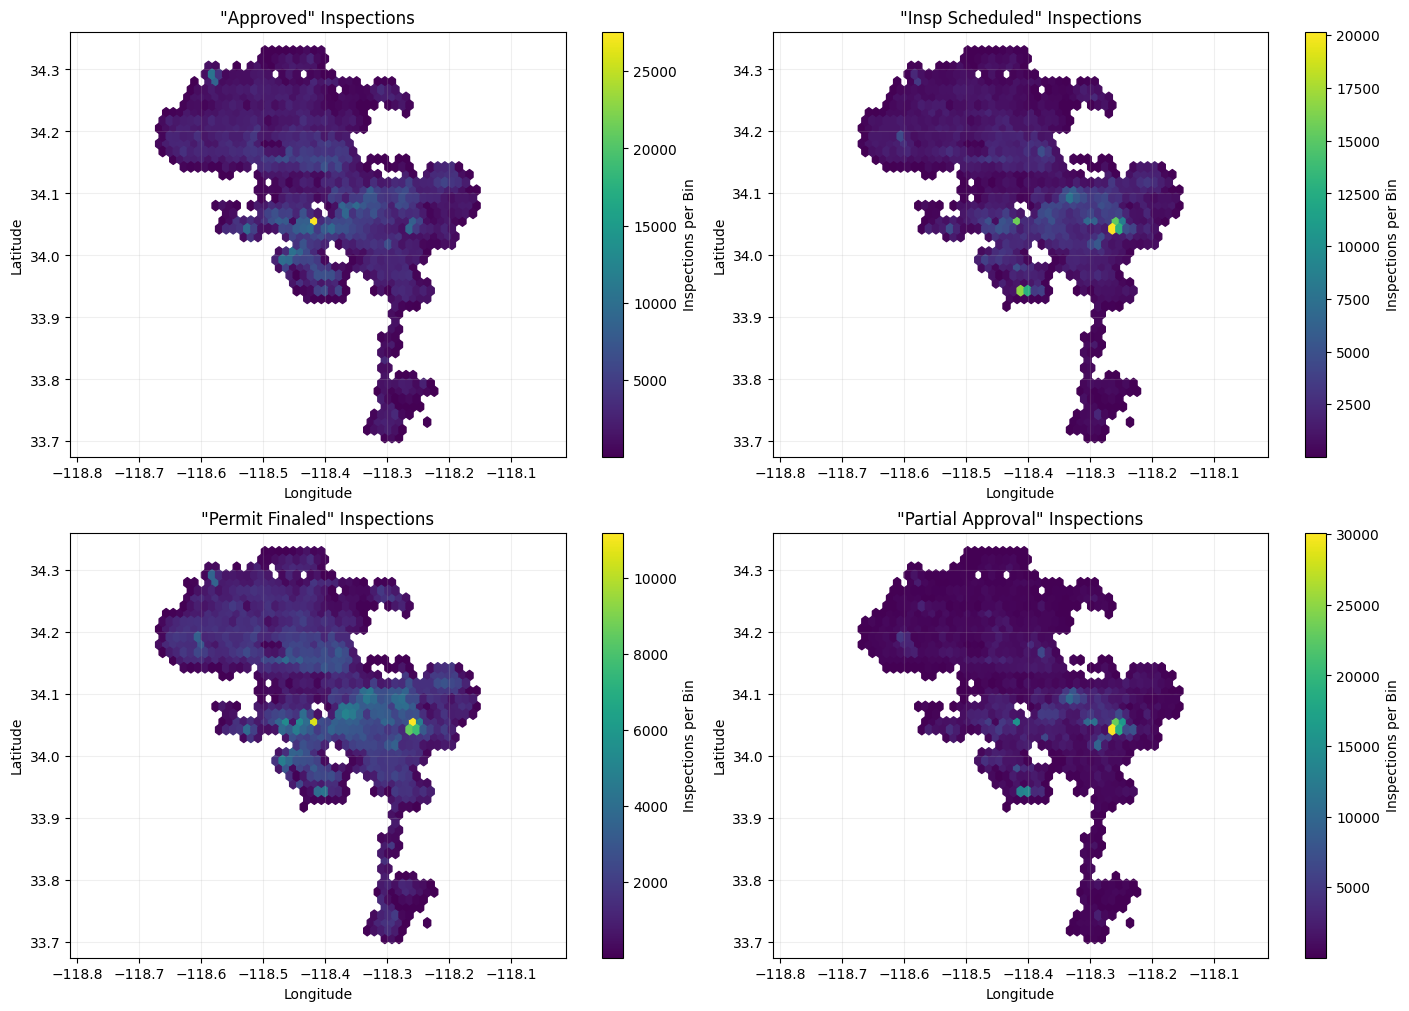

In [66]:
results_to_plot = ["Approved", "Insp Scheduled", "Permit Finaled", "Partial Approval"]

gridsize = 45
plot_cmap = 'viridis'
min_bin_count = 5

fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
axes = axes.flatten() 

for i, result in enumerate(results_to_plot):
    ax = axes[i]
    result_df = df[df['Inspection Result'] == result].dropna(subset=['Latitude', 'Longitude'])
    
    hb = ax.hexbin(
        result_df['Longitude'], result_df['Latitude'],
        gridsize=gridsize, cmap=plot_cmap, mincnt=min_bin_count
    )
    fig.colorbar(hb, ax=ax, label='Inspections per Bin')
    
    ax.set(title=f'"{result}" Inspections', xlabel='Longitude', ylabel='Latitude')
    ax.axis('equal')
    ax.grid(True, alpha=0.2)

# Hide any unused subplot slots
for j in range(len(results_to_plot), len(axes)):
    axes[j].set_visible(False)

plt.show()

In [55]:
result_counts = df['Permit Status'].value_counts()
display(result_counts)

Permit Status
Issued                            7230192
Permit Finaled                    1768262
CofO Issued                        522072
CofO in Progress                   247303
Permit Expired                      64587
Permit Closed                       40482
OK for CofC                         12538
Application Submitted               11393
CofO Corrected                       7258
CofC Issued                          5633
Re-Activate Permit                   1677
Refund Completed                      833
Refund in Progress                    702
Permit Withdrawn                      581
Ready to Issue                        205
Intent to Revoke                      162
TCO Issued                            147
PC Info Complete                      137
TCO Renewed                           115
No Progress                           109
Insp Scheduled                         96
Application Withdrawn                  68
CofO Superseded                        58
CofO Revoked        

In [65]:
count = df[df['Inspection Result'].isna() & df['PERMIT'].notna()].shape[0]

display(count)

481421